In [142]:
import os
import sys

import numpy as np
import pandas as pd

from datetime import datetime
from statsmodels.tsa.arima_model import ARMA

class trainResidualSeasonality:
    
    def __init__(self, event):

        # Read in dataframe
        self.dataframe       = event['dataframe'] # pd.read_csv(event['dataframe'],parse_dates=True,index_col='time')

        # Training information
        self.forecastHorizon = event['forecastHorizon']
        self.trainDFLength   = event['trainDFLength']
        self.order           = event['order']
        self.diff            = event['diff']
        self.product         = event['product']
        self.column          = event['column']
        self.b_adjust        = event['b_adjust']

        # number of mdoels to be trained
        self.num_models      = event['num_models']

        # store l of forecast
        self.forecastList    = []

        self.event = event

    def arma_model(self):

        cacheForecasts = {

            'asofdate':[],
            'pointForecast':[],
            self.column:[],
            'forecastday':[],
            'product_name':[],
            'MA_50':[],
            'MA_diff_50':[],


        }

        cacheMetadata = {

            'asofdate':[],
            'aic':[],
            'bic':[],
            'hqic':[],
            'mae':[],
            'mse':[],
            'forecastHorizon':[],
            'diff':[],
            'trainDFLength':[],
            'num_models':[],
            'order_p':[],
            'order_q':[],
            'time':[],
            'product_name':[],

        }

        for param in range(1,1+self.order[0]):
            cacheMetadata[f'ar.L{param}.{self.column}'] = []

        for param in range(1,1+self.order[1]):
            cacheMetadata[f'ma.L{param}.{self.column}'] = []

        if self.diff:
            diff   = np.log(self.dataframe[self.column]).diff(1).dropna(axis=0)
    
            for j in range(1,self.forecastHorizon+1):
                self.forecastList.append(j)

            i = 0
            while i < self.num_models:

   
                try:
                    start = datetime.now()

                    # training the model
                    mod = ARMA(diff[i:self.trainDFLength+i], order=self.order)
                    res = mod.fit()
                    
                    # converting log forecast
                    fcast = res.forecast(self.forecastHorizon)

                    # Calculating forecasts
                    cacheForecasts['pointForecast'].append(np.exp(fcast[0])*self.dataframe[self.column][self.trainDFLength+i])
                    cacheForecasts[self.column].append(self.dataframe[self.column][self.trainDFLength+i+1:self.trainDFLength+self.forecastHorizon+i+1])

                    # store model metadata
                    cacheMetadata['asofdate'].append(self.dataframe.index[self.trainDFLength+i])
                    cacheMetadata['aic'].append(res.aic)
                    cacheMetadata['bic'].append(res.bic)
                    cacheMetadata['hqic'].append(res.hqic)
                    cacheMetadata['mae'].append(np.mean(np.abs(res.resid)))
                    cacheMetadata['mse'].append(np.mean(np.square(res.resid)))

                    # event_data
                    cacheMetadata['forecastHorizon'].append(self.forecastHorizon)
                    cacheMetadata['diff'].append(self.diff)
                    cacheMetadata['trainDFLength'].append(self.trainDFLength)
                    cacheMetadata['num_models'].append(self.num_models)
                    cacheMetadata['order_p'].append(self.order[0])
                    cacheMetadata['order_q'].append(self.order[1])
                    cacheMetadata['product_name'].append(self.product)

                    for param in range(1,1+self.order[0]):
                        cacheMetadata[f'ar.L{param}.{self.column}'].append(res.bse[f'ar.L{param}.{self.column}'])

                    for param in range(1,1+self.order[1]):
                        cacheMetadata[f'ma.L{param}.{self.column}'].append(res.bse[f'ma.L{param}.{self.column}'])

                    cacheMetadata['time'].append(datetime.now() - start)

                except:
                    cacheForecasts['pointForecast'].append(self.dataframe[self.column][self.trainDFLength+i+1:self.trainDFLength+self.forecastHorizon+i+1])

                i+=self.forecastHorizon

            # Fixing data formats
            cacheForecasts['pointForecast'] = np.concatenate(cacheForecasts['pointForecast'])
            cacheForecasts['forecastday']   = np.array(self.forecastList*(int(len(cacheForecasts['pointForecast'])/int(self.forecastHorizon))))
            cacheForecasts[self.column]     = np.array(self.dataframe[self.column][1+self.trainDFLength:1+self.trainDFLength+len(cacheForecasts['pointForecast'])])
            cacheForecasts['asofdate']      = np.array(self.dataframe[self.column][1+self.trainDFLength:1+self.trainDFLength+len(cacheForecasts['pointForecast'])].index)
            cacheForecasts['product_name']  = np.array([self.product]*int(len(cacheForecasts['pointForecast'])))
            cacheForecasts['MA_50']         = self.dataframe[self.column].rolling(50).mean()[1+self.trainDFLength:1+self.trainDFLength+len(cacheForecasts['pointForecast'])]
            cacheForecasts['MA_diff_50']    = self.dataframe[self.column].rolling(50).mean().diff(1)[1+self.trainDFLength:1+self.trainDFLength+len(cacheForecasts['pointForecast'])]

            
            pd.DataFrame(cacheForecasts).to_csv(f'forecasts_{self.product}_{self.order}_{self.diff}_{self.forecastHorizon}.csv')
            pd.DataFrame(cacheMetadata).to_csv(f'metadata_{self.product}_{self.order}_{self.diff}_{self.forecastHorizon}.csv')
        
        return (pd.DataFrame(cacheForecasts),pd.DataFrame(cacheMetadata))


In [143]:
seasonal_event = {'dataframe':r'C:\Users\James Stanley\Documents\GitHub\backtest_utilities\data\daily\commodities\energy\natural_gas\NYMEX_DL_NG1!, 1D.csv'}

In [144]:

def seasonal_test(seasonal_event):

    from statsmodels.tsa.seasonal import seasonal_decompose

    seasonal_event['dataframe'] = pd.read_csv(seasonal_event['dataframe'],parse_dates=True,index_col='time') 

    seasonal_result = seasonal_decompose(seasonal_event['dataframe']['close'], model="multiplicative",period=252)

    trend    = seasonal_result.trend
    seasonal = seasonal_result.seasonal
    residual = seasonal_result.resid

    seasonal_event['column'] = 'resid'


    arma_model_event = {

    'dataframe':residual.reset_index().set_index(['time']), #['resid'],
    'forecastHorizon':5,
    'trainDFLength':252,
    'order':(2,2),
    'num_models':1000,
    'diff':True,
    'product':'NG1',
    'column':'resid',
    'b_adjust':True,

    }

    model      = trainResidualSeasonality(arma_model_event)
    arma_model = model.arma_model()

    forecast_df = arma_model[0]


    merge_df = pd.concat([forecast_df,trend.reset_index().set_index(['time'])['trend'],seasonal.reset_index().set_index(['time'])['seasonal']],axis=1)
    merge_df = merge_df.dropna(axis=0)

    merge_df['seasonalEstimate'] = merge_df['pointForecast']*merge_df['trend']*merge_df['seasonal']
    merge_df = merge_df[['seasonalEstimate','pointForecast','trend','seasonal','resid','product_name']]

    return (merge_df,arma_model[0],arma_model[1])

In [145]:
# model_test = train_arma(arma_model_event)
df = seasonal_test(seasonal_event)

{'dataframe': 'C:\\Users\\James Stanley\\Documents\\GitHub\\backtest_utilities\\data\\daily\\commodities\\energy\\natural_gas\\NYMEX_DL_NG1!, 1D.csv'}


c:\Users\James Stanley\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\Users\James Stanley\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:581: ValueW

In [146]:
import matplotlib.pyplot as plt

In [147]:
seasonal_event = {'dataframe':r'C:\Users\James Stanley\Documents\GitHub\backtest_utilities\data\daily\commodities\energy\natural_gas\NYMEX_DL_NG1!, 1D.csv'}

In [148]:
merge = pd.concat([df[0],pd.read_csv(seasonal_event['dataframe'],parse_dates=True,index_col='time')],axis=1)
merge = merge[['seasonalEstimate','close']]


In [149]:
merge = merge.dropna(axis=0)

In [165]:
merge['MA50'] = merge['close'].rolling(50).mean()
merge['MA_diff_50'] = merge['MA50'].diff(1)
merge = merge.dropna(axis=0)

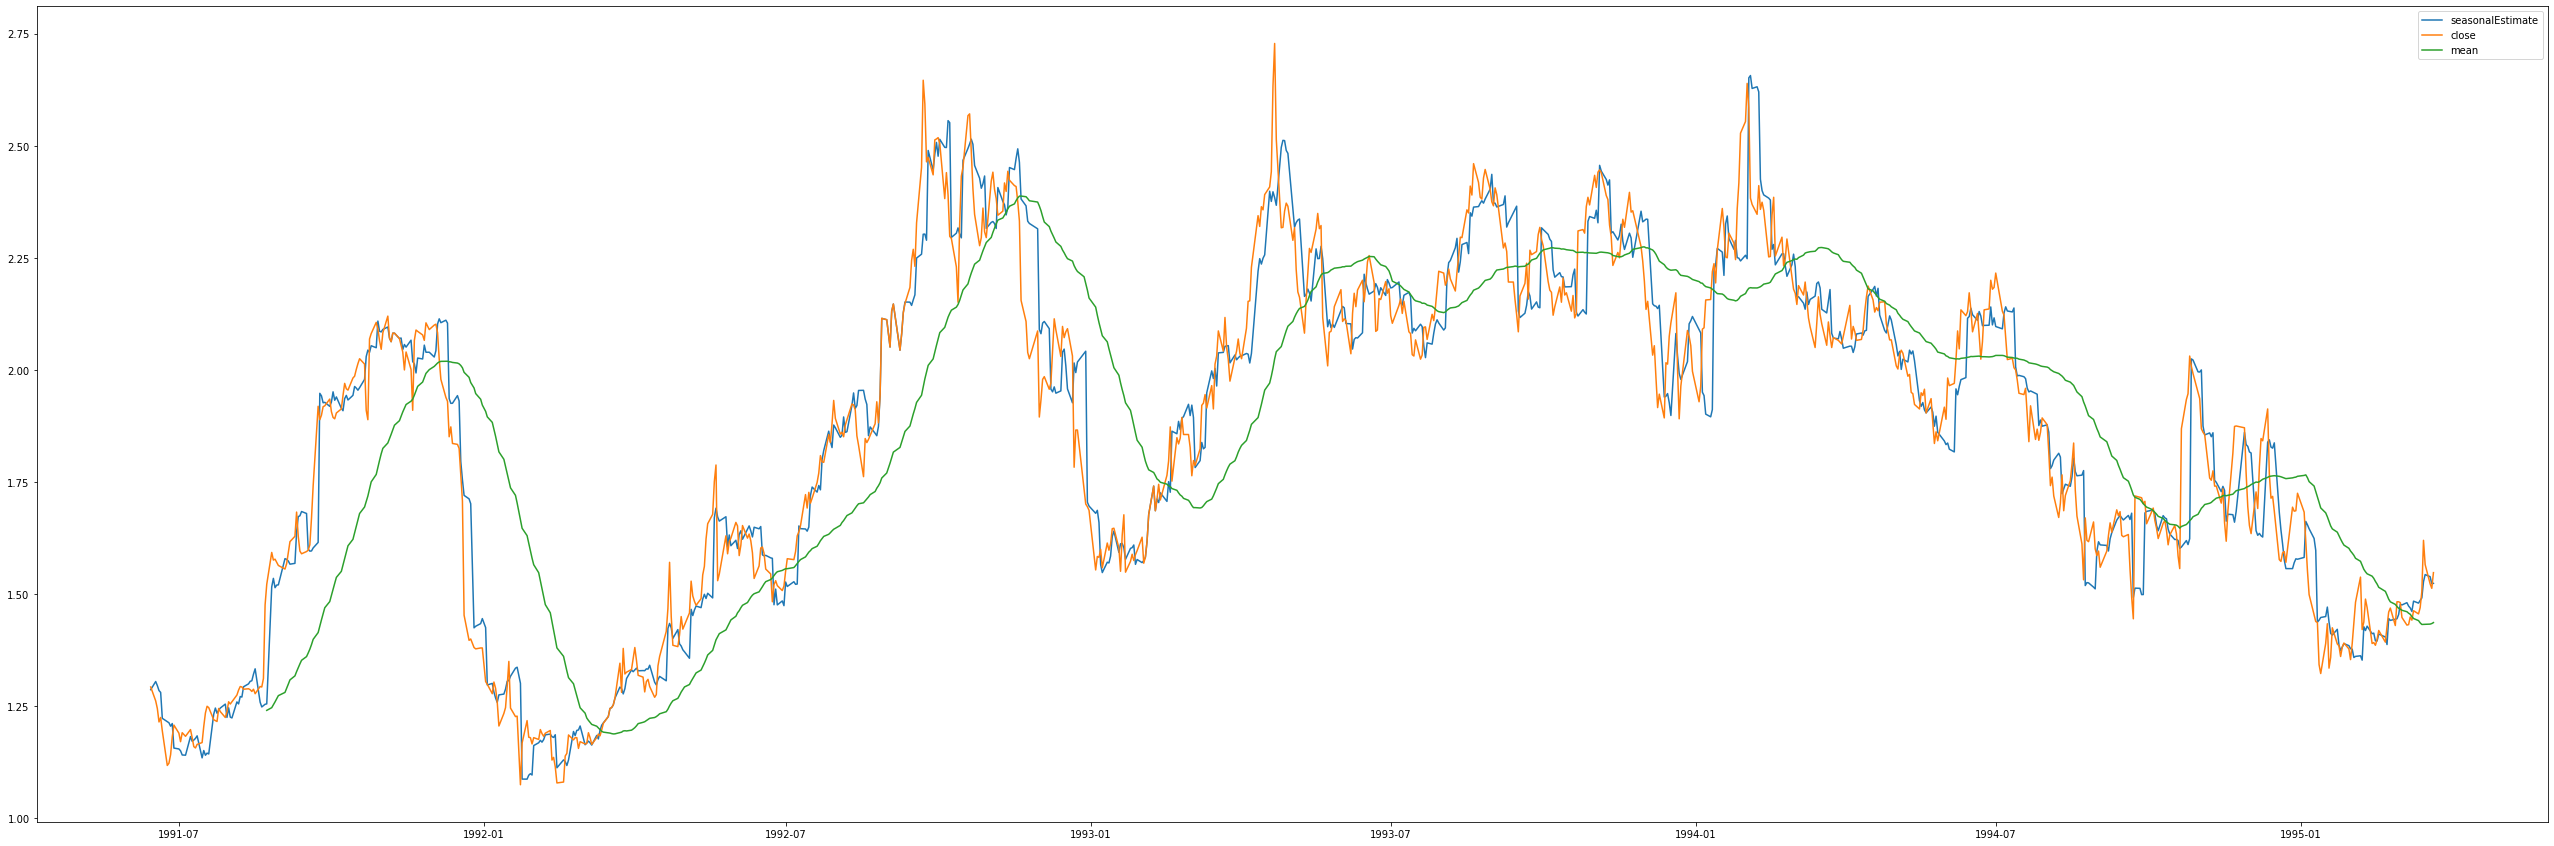

In [166]:
plt.figure(figsize=(45,15))

plt.plot(merge['seasonalEstimate'])
plt.plot(merge['close'])
plt.plot(merge['close'].rolling(50).mean())

plt.legend(['seasonalEstimate','close','mean'])

plt.show()

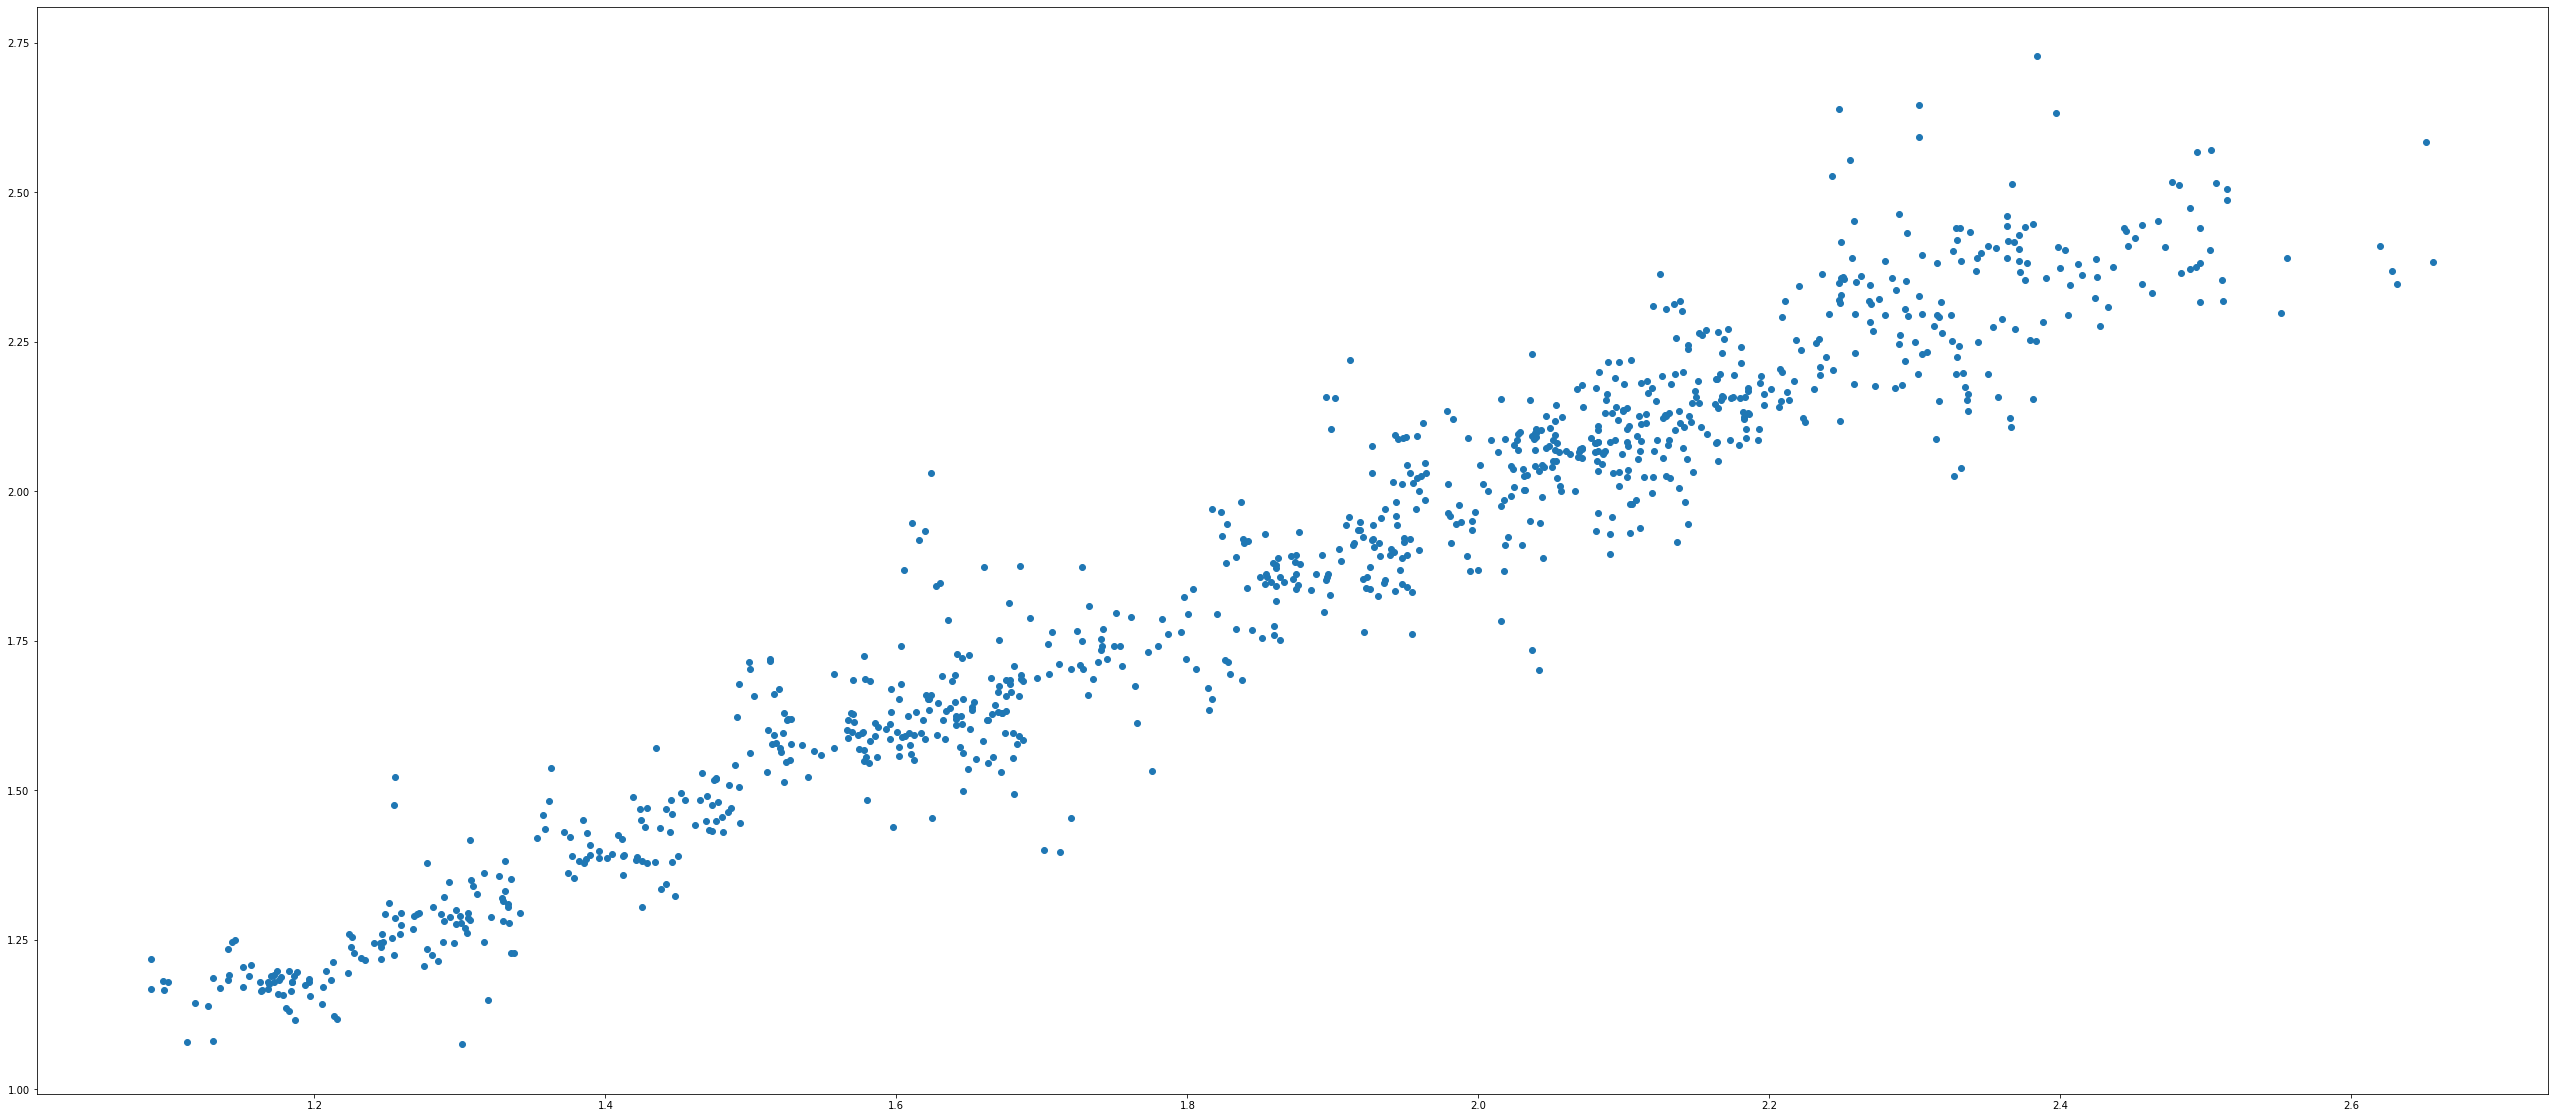

In [167]:
plt.figure(figsize=(45,20))

plt.scatter(merge['seasonalEstimate'],merge['close'])

plt.show()

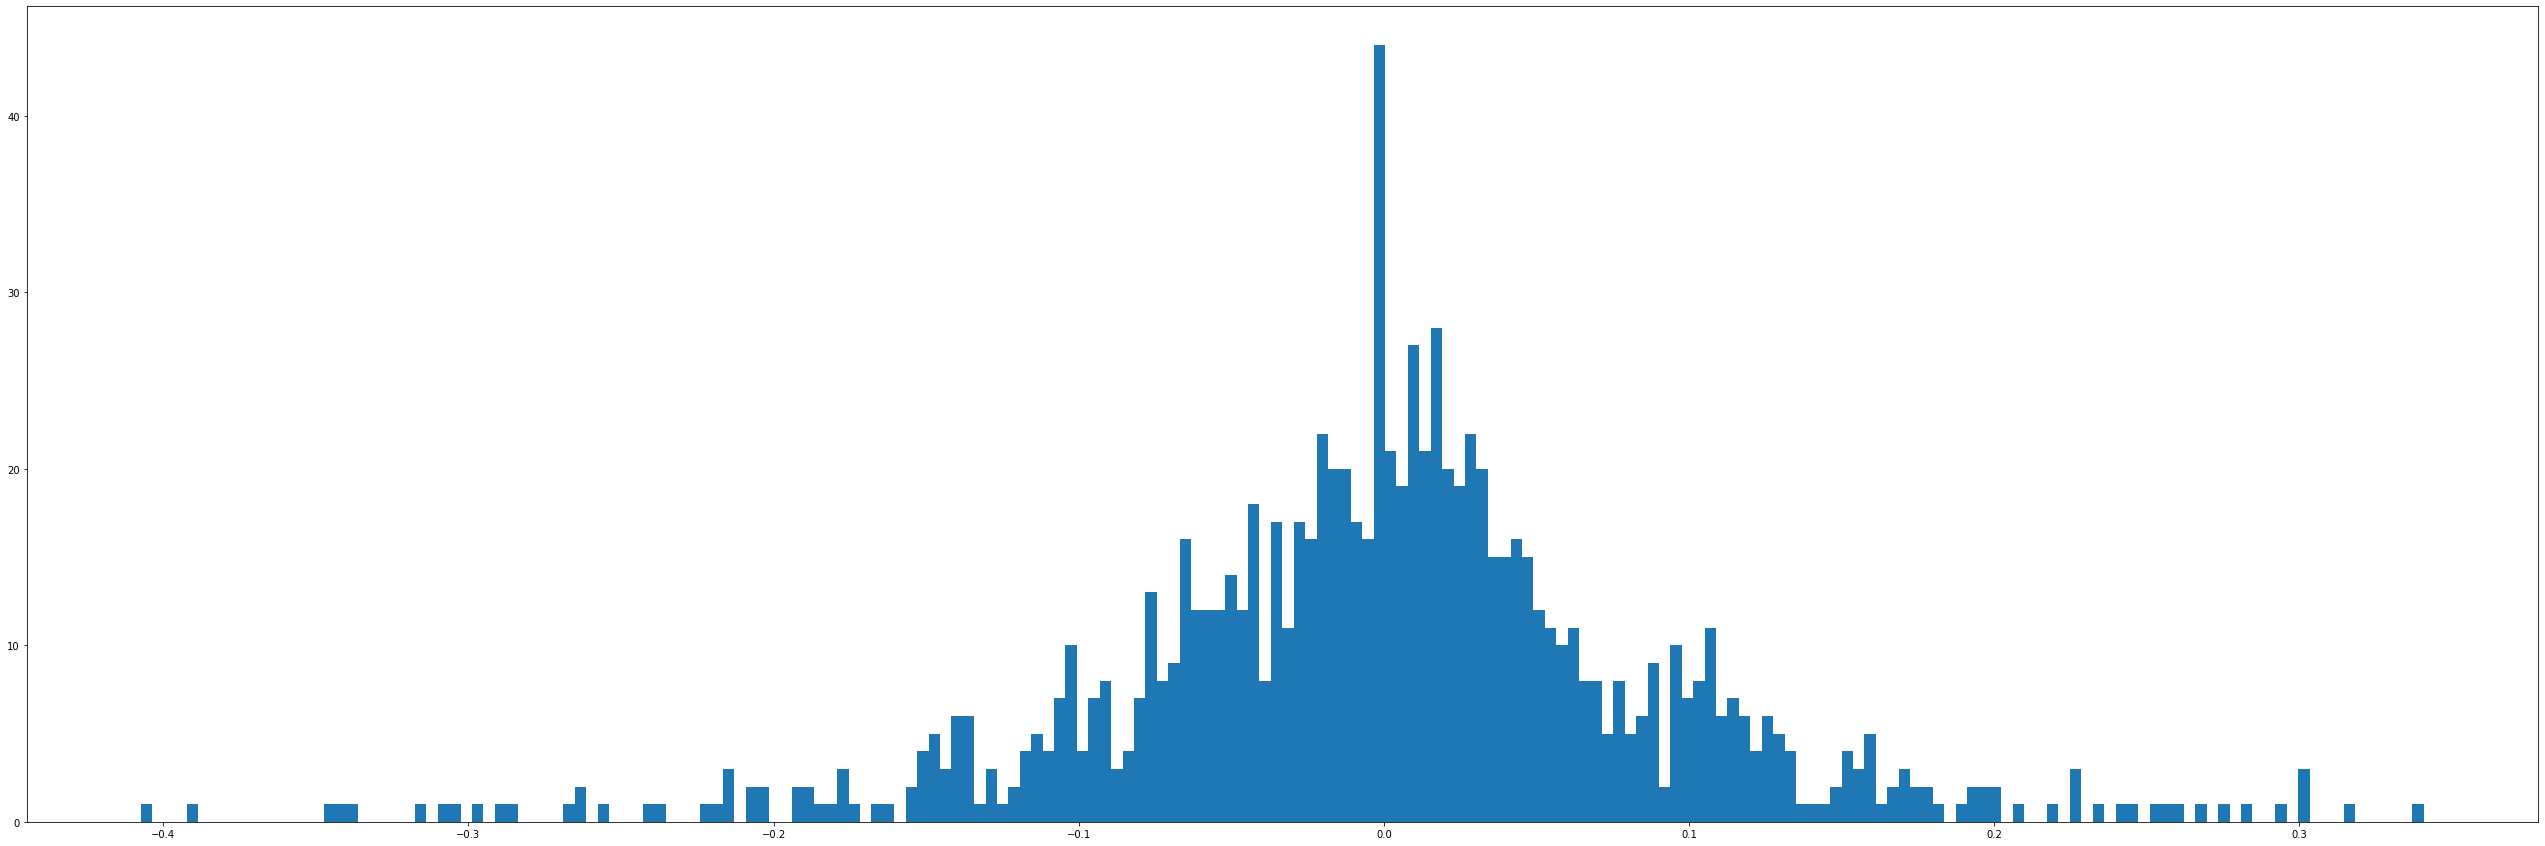

In [168]:
plt.figure(figsize=(45,15))
plt.hist((merge['seasonalEstimate']-merge['close']).reset_index()[0],bins=200)
plt.show()

# Calculating PnL

In [169]:
merge.to_csv(r'forecast.csv')

In [170]:

pnl_event = {

    'forecastHorizon':5,
    'dataframe':r'C:\Users\James Stanley\Documents\GitHub\backtest_utilities\approved_projects\seasonal_arma\forecast.csv',
    'threshold':0.01,
    'reinvest':True,
    'strategy':'arma_threshold_ma',
}



In [173]:
merge = merge.reset_index()

In [174]:
cachePnL = {

    'asofdate':[],
    'pnl':[],
    'strategy':[],
    'positionType':[],

}

# name of string to save output
cache_pnl_str = pnl_event['dataframe'].replace("forecasts","pnl_armaspreadthreshold")
cache_trades_str = pnl_event['dataframe'].replace("forecasts","tradelevelpnl_armaspreadthreshold")


# reading in dataframe
pnl_event['dataframe'] = merge.reset_index()

# calculating the difference
close_diff    = pnl_event['dataframe']['close'].diff(1).fillna(0) #.diff(pnl_event['forecastHorizon'])

forecast_diff = pnl_event['dataframe']['seasonalEstimate'].diff(pnl_event['forecastHorizon'])

i = 0
while i < len(pnl_event['dataframe']) - pnl_event['forecastHorizon']:
    if np.abs(forecast_diff[i+pnl_event['forecastHorizon']]) > pnl_event['threshold'] and ((forecast_diff[i+pnl_event['forecastHorizon']] > 0 and pnl_event['dataframe']['MA_diff_50'][i] > 0) or (forecast_diff[i+pnl_event['forecastHorizon']] <= 0 and pnl_event['dataframe']['MA_diff_50'][i] <= 0)):

        if forecast_diff[i+pnl_event['forecastHorizon']] > 0 and pnl_event['dataframe']['MA_diff_50'][i] > 0:
            for j in range(0,pnl_event['forecastHorizon']):
                cachePnL['pnl'].append(close_diff[i + j])
                cachePnL['positionType'].append('long')

        if forecast_diff[i+pnl_event['forecastHorizon']] <= 0 and pnl_event['dataframe']['MA_diff_50'][i] <= 0:
            for j in range(0,pnl_event['forecastHorizon']):
                cachePnL['pnl'].append(-close_diff[i + j])
                cachePnL['positionType'].append('short')

    else:

        for j in range(0,pnl_event['forecastHorizon']):
            cachePnL['pnl'].append(0)
            cachePnL['positionType'].append('no_position')

    i+=pnl_event['forecastHorizon']

cachePnL['asofdate'] = pnl_event['dataframe']['index'][pnl_event['forecastHorizon']:].to_list()
cachePnL['strategy'] = [pnl_event['strategy']]*len(cachePnL['asofdate'])

# saving dataframes
pnl_df   = pd.DataFrame(cachePnL)

print(pnl_df)

     asofdate    pnl           strategy positionType
0           5 -0.000  arma_threshold_ma        short
1           6  0.031  arma_threshold_ma        short
2           7  0.017  arma_threshold_ma        short
3           8  0.030  arma_threshold_ma        short
4           9 -0.010  arma_threshold_ma        short
..        ...    ...                ...          ...
940       945  0.000  arma_threshold_ma  no_position
941       946  0.000  arma_threshold_ma  no_position
942       947  0.000  arma_threshold_ma  no_position
943       948  0.000  arma_threshold_ma  no_position
944       949  0.000  arma_threshold_ma  no_position

[945 rows x 4 columns]


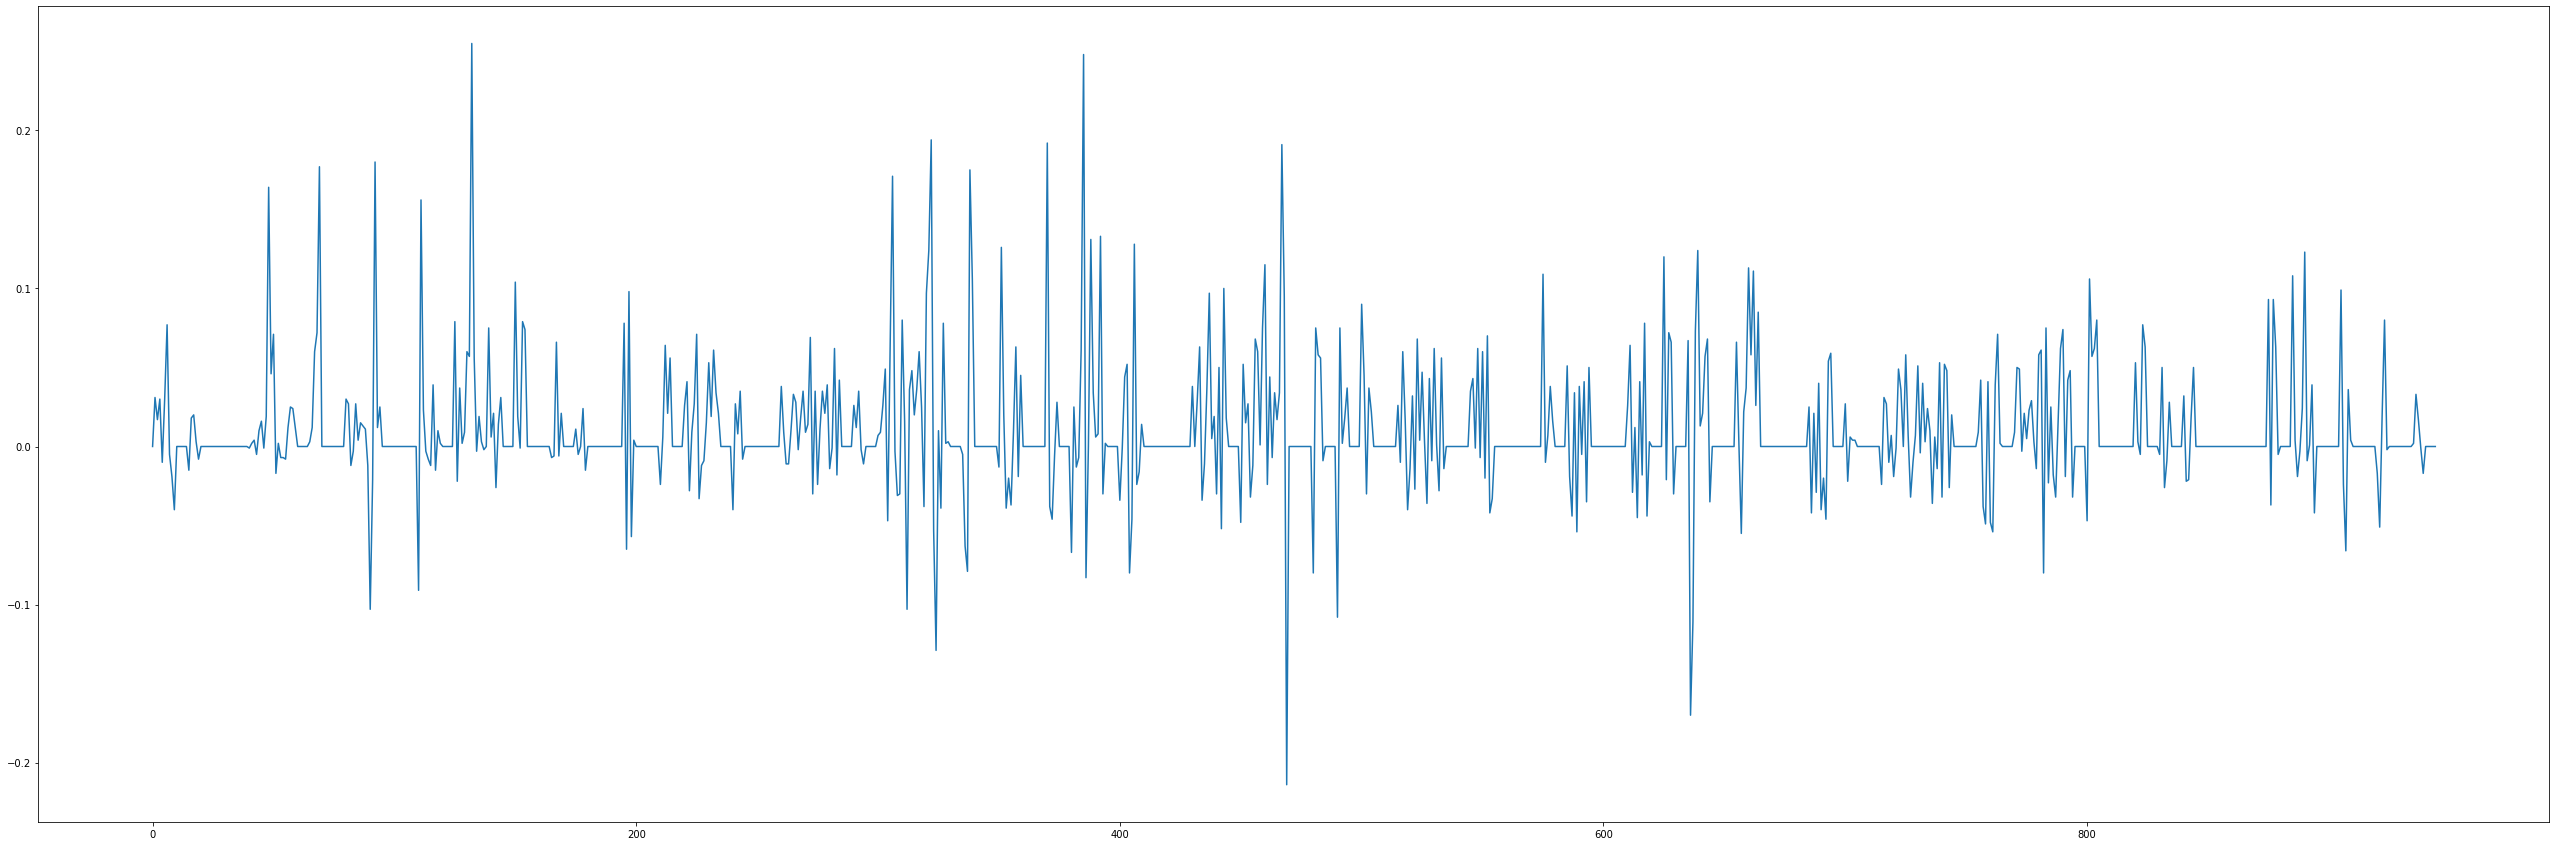

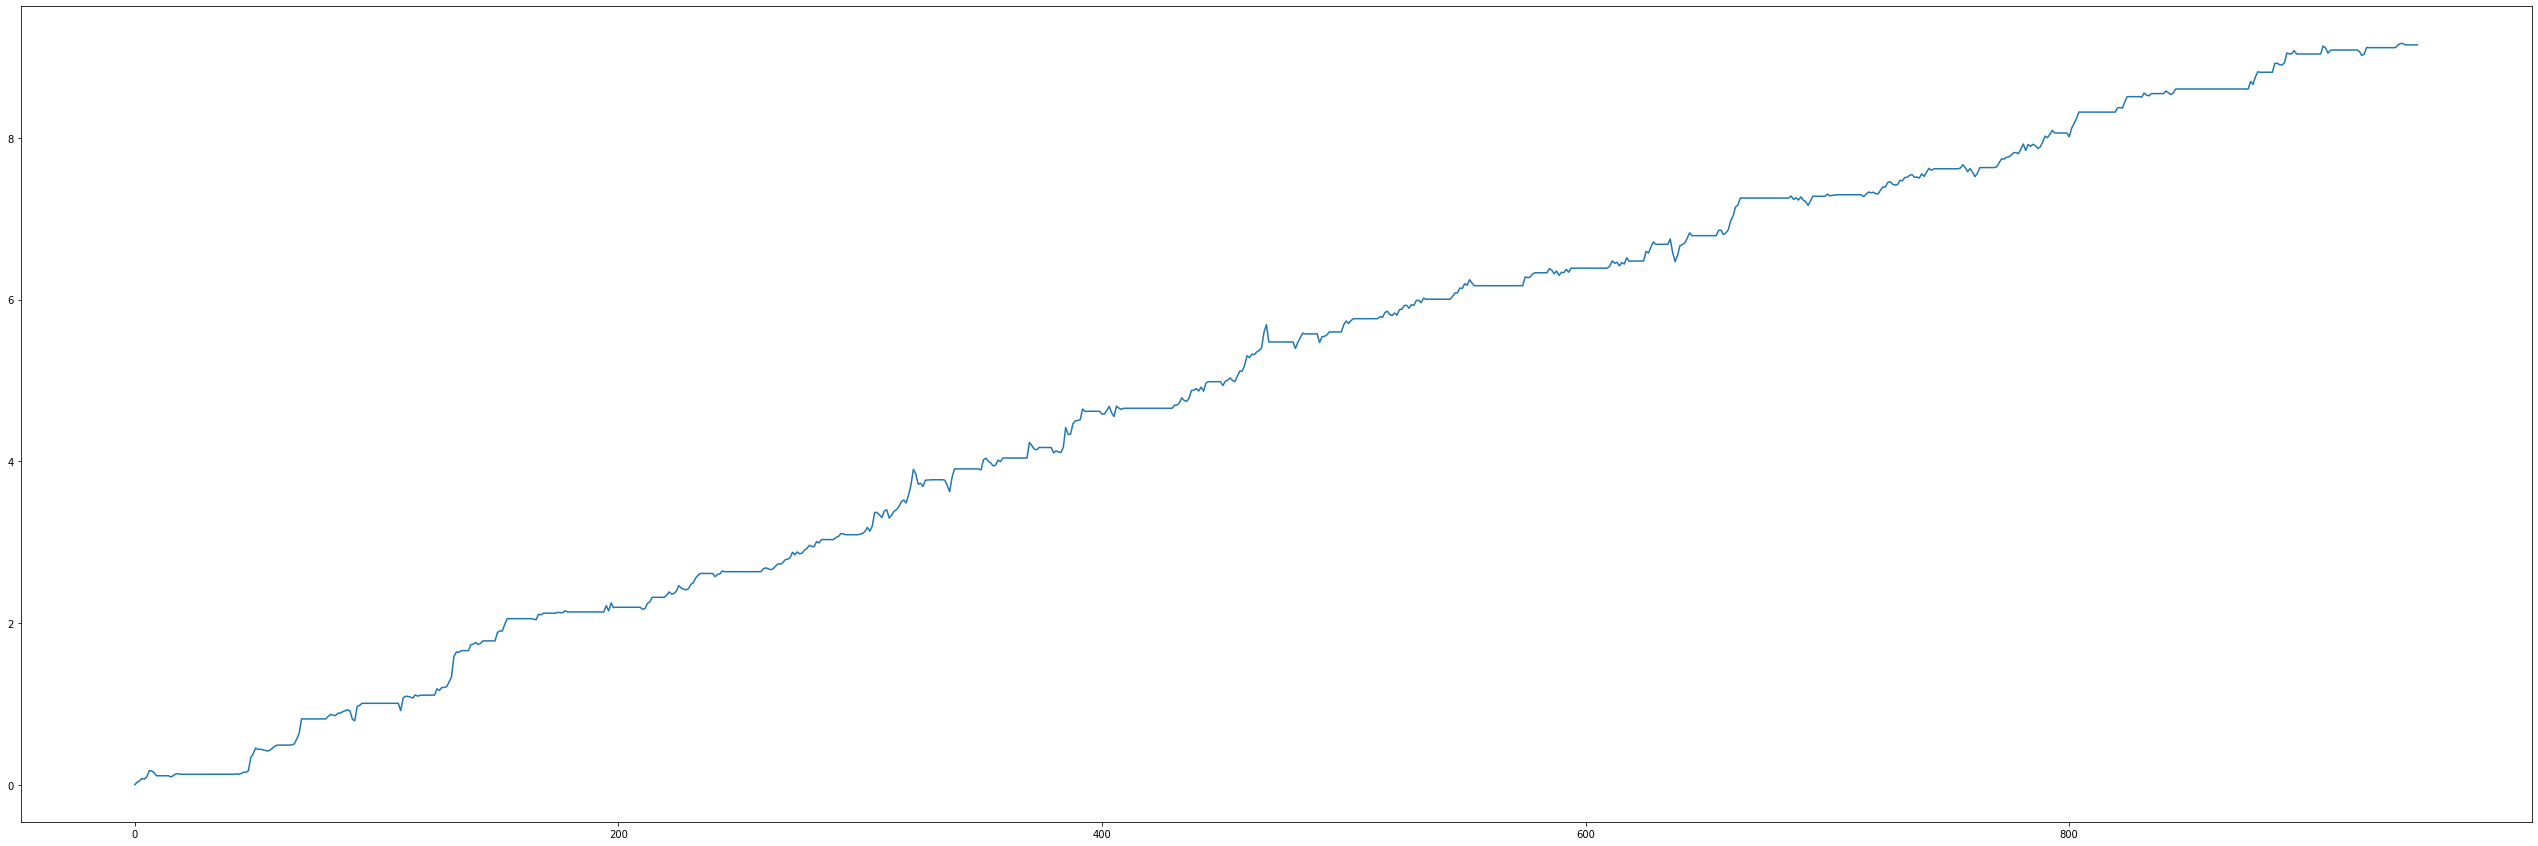

In [177]:
plt.figure(figsize=(45,15))

plt.plot(pnl_df['pnl'])

plt.show()

plt.figure(figsize=(45,15))

plt.plot(pnl_df['pnl'].cumsum())

plt.show()